# 4장. 좋은 훈련 데이터셋 만들기: 데이터 전처리

* 데이터셋에서 누락된 값을 제거하거나 대체하기
* 머신 러닝 알고리즘을 위해 범주형 데이터 변환하기
* 모델과 관련이 높은 특성 선택하기

## 4.1 누락된 데이터 다루기

데이터셋에서 샘플을 제거하거나 다른 샘플이나 특성에서 누락된 값을 대체하는 기법

### 4.1.1 테이블 형태 데이터에서 누락된 값 식별


In [1]:
import pandas as pd
from io import StringIO

csv_data = \
    '''A,B,C,D
    1.0,2.0,3.0,4.0
    5.0,6.0,,8.0
    10.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [2]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

* 사이킷런에서 데이터를 적재할 때, as_frame 매개변수를 True로 지정하면 판다스 데이터프레임으로 반환
* 이제 auto로 바뀌는데 이는 데이터가 희소하지 않으면 기본적으로 판다스 데이터프레임으로 반환한다.

### 4.1.2 누락된 값이 있는 훈련 샘플이나 특성 제외

* dropna 메서드:
  * axis = 0 : NA가 있는 행 삭제
  * axis = 1 : NA가 있는 열 삭제
  * inplace = True: 새로운 데이터프레임을 반환하지 않고 주어진 데이터프레임 자체를 바꿈
  * how = 'all': 모든 열이 NaN일 때만 행을 삭제
  * thresh = 4: NaN이 아닌 값이 네 개보다 작은 행을 삭제
  * subset = ['C']: 특정 열에 NaN이 있는 행만 삭제

너무 많은 데이터를 제거하면 안정된 분석이 불가능하다.

### 4.1.3 누락된 값 대체

가장 흔한 보간 기법 중 하나는 평균으로 대체하는 것 - sklearn의 SimpleImputer 클래스  
scikit-learn의 0.24버전에서 아직 실험 중이지만, IterativeImputer 클래스로 누락된 값이 있는 한 특성을 타깃으로 삼고 다른 특성을 사용해서 모델을 훈련하여 예측  

더 쉬운 방법은 판다스의 fillna 메서드에 매개변수로 누락된 값을 채울 방법을 전달  
* df.fillna(df.mean())

fillna 메서드의 method 매개변수를 사용하여 누락된 값을 채울 수도 있음  
* df.fillna(method='bfill') # 누락된 값을 다음 행의 값으로 채움
* df.fillna(method='ffill') # 누락된 값을 이전 행의 값으로 채움
* df.fillna(method='ffill', axis=1) # 행이 아닌 열을 사용해 이전 열의 값으로 누락된 값을 채움

In [3]:
# 특성 열에서 계산한 평규능로 바꾸기
from sklearn.impute import SimpleImputer
import numpy as np
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

### 4.1.4 사이킷런 추정기 API 익히기

변환기 클래스 = fit() + transform()  
* fit: 훈련 데이터에서 모델 파라미터를 학습
* transform: 학습한 파라미터로 데이터를 변환

추정기는 추가로 predict() 메서드가 있음

## 4.2 범주형 데이터 다루기

### 4.2.1 판다스를 사용한 범주형 데이터 인코딩


In [4]:
# 새 데이터 만들기
import pandas as pd
df = pd.DataFrame([
                    ['green', 'M', 10.1, 'class1'],
                    ['red', 'L', 13.5, 'class2'],
                    ['blue', 'XL', 15.3, 'class1']
                   ])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


In [5]:
size_mapping = {
                'XL':3,
                'L':2,
                'M':1
}

In [6]:
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [7]:
# 정수로 매핑된 것을 원래대로
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### 4.2.3 클래스 레이블 인코딩

정수 배열로 전달, enumerate 사용

In [8]:
# 참고할 키:값 쌍의 딕셔너리 만들기
import numpy as np
class_mapping = {label: idx for idx, label in 
                 enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [9]:
# 정수값으로 바꾸기
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [10]:
# 다시 원본 문자열의 형태로 돌리기
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [11]:
# 사이킷런 이용하기
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

In [12]:
# 원본 문자열 형태로 되돌리기
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### 4.2.4 순서가 없는 특성에 원-핫 인코딩 적용

일단, 앞 데이터의 color 열은 순서가 없는 범주형 데이터이므로 앞과 같은 방식으로 변경하기

In [13]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [14]:
# 여러 열을 한번에 정수 변환하기
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder(dtype=int)
col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])
X_trans = col_trans.fit_transform(df)
X_trans

array([[1],
       [2],
       [0]])

In [15]:
# 다시 문자열로 변환
col_trans.named_transformers_['ord_enc'].inverse_transform(X_trans)

array([['green'],
       ['red'],
       ['blue']], dtype=object)

In [16]:
# 원핫인코딩으로 바꾸기 (하나의 열만 바꾸기)
from sklearn.preprocessing import OneHotEncoder
X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [17]:
# 여러 특성이 있을 때 특정 열만 바꾸고 싶으면 위의 ColumnTransformer 사용
from sklearn.compose import ColumnTransformer
X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]),
    ('nothing', 'passthrough', [1, 2])
])
c_transf.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

In [18]:
# Pandas의 get_dummies 메서드: 문자열 열만 변환하고 나머지 열은 그대로
pd.get_dummies(df[['color', 'size', 'price']])

,size,price,color_blue,color_green,color_red
0,1,10.1,0,1,0
1,2,13.5,0,0,1
2,3,15.3,1,0,0


In [19]:
# 중복된 내지 상호 의존적인 열을 삭제하기
color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([
    ('onehot', color_ohe, [0]),
    ('nothing', 'passthrough', [1, 2])
])
c_transf.fit_transform(X)

array([[1.0, 0.0, 1, 10.1],
       [0.0, 1.0, 2, 13.5],
       [0.0, 0.0, 3, 15.3]], dtype=object)

## 4.3 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누기

In [20]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/'
                      'wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
print('클래스 레이블', np.unique(df_wine['Class label']))
df_wine.head()

클래스 레이블 [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [21]:
# train, test set 나누기
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

*reference)* 머신러닝의 모델 평가와 모델 선택, 알고리즘 선택 (http://arxiv.org/pdf/1811.12808.pdf)
* 번역본: https://bit.ly/2pUx9AA

## 4.4 특성 스케일 맞추기
결정 트리, 랜덤 포레스트는 특성 스케일 조정에 대해 걱정할 필요가 없지만, 경사 하강법이나 k-최근접 이웃에서는 특성의 스케일이 같을 때 훨씬 성능이 좋다.  
**정규화**: 특성의 스케일을 [0, 1] 범위에 맞추는 것으로 **최소-최대 스케일 변환**의 특별한 경우  
$$x_{norm}^{(i)}=\frac{x^{(i)}-x_{min}}{x_{max}-x_{min}}$$
사이킷런으로 구현 가능

In [22]:
# min-max scaling
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

**표준화**: 특성의 평균을 0에 맞추고 표준 편차를 1로 만들어 정규 분포와 같은 특징을 가지도록 만듦  
이상치 정보가 유지 -> 이상치에 덜 민감  
$$x_{std}^{(i)}=\frac{x^{(i)}-\mu_x}{\sigma_x}

In [23]:
# 표준화와 정규화 예제 코드
ex = np.array([0, 1, 2, 3, 4, 5])
print('표준화: ', (ex - ex.mean()) / ex.std())
print('정규화: ', (ex - ex.min()) / (ex.max() - ex.min()))

표준화:  [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
정규화:  [0.  0.2 0.4 0.6 0.8 1. ]


In [24]:
# 표준화를 위한 Scikit learn class
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

* 특성 스케일을 조정하는 다른 좋은 방법: `RobustScaler`
* 이상치가 많이 포함된 작은 데이터셋을 다룰 때 도움  
* 특성 열마다 독립적으로 작용하며 중간 값을 뺀 다음 1사분위수와 3사분위수의 차로 나누어 데이터셋의 스케일을 조정
* 극단적인 값과 이상치에 영향을 덜 받음

$$x_{robust}^{(i)}=\frac{x^{(i)}-q_2}{q_3-q_1}$$


In [25]:
# Robust scaler
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
X_train_robust = rbs.fit_transform(X_train)
X_test_robust = rbs.transform(X_test)

In [26]:
# 넘파이로 구현하기
(ex - np.percentile(ex, 50)) / (np.percentile(ex, 75) - np.percentile(ex, 25))

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

In [27]:
# MaxAbsScaler: 각 특성 별로 데이터를 최대 절대값으로 나눔
from sklearn.preprocessing import MaxAbsScaler
mas = MaxAbsScaler()
X_train_maxabs = mas.fit_transform(X_train)
X_test_maxabs = mas.transform(X_test)

In [28]:
# 넘파이로 구현하기
ex / np.max(np.abs(ex))

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [29]:
# 대응하는 함수로 구현해 보기
from sklearn.preprocessing import scale, minmax_scale, robust_scale, maxabs_scale
print('StandardScaler: ', scale(ex))
print('MinMaxScaler: ', minmax_scale(ex))
print('RobustScaler: ', robust_scale(ex))
print('MaxAbsScaler: ', maxabs_scale(ex))

StandardScaler:  [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
MinMaxScaler:  [0.  0.2 0.4 0.6 0.8 1. ]
RobustScaler:  [-1.  -0.6 -0.2  0.2  0.6  1. ]
MaxAbsScaler:  [0.  0.2 0.4 0.6 0.8 1. ]


* MaxAbsScaler는 데이터를 중앙에 맞추지 않아 희소 행렬을 사용할 수 있다.
* RobustScaler는 transform() 메서드로 희소 행렬을 변환할 수 있다.
* StandardScaler는 `with_mean=False`로 지정하면 희소 행렬을 사용할 수 있다.

* `Normalizer` 클래스, `normalize()` 함수는 샘플별로 정규화를 수행, 희소 행렬도 처리 가능
* 사용할 노름을 L1, L2, max로 지정

In [30]:
# 희소행렬 만들기
from scipy import sparse
X_train_sparse = sparse.csr_matrix(X_train)
X_train_maxabs = mas.fit_transform(X_train_sparse)

In [31]:
X_train_robust = rbs.transform(X_train_sparse)

In [32]:
# Normalizer 클래스 사용
from sklearn.preprocessing import Normalizer
nrm = Normalizer()
X_train_l2 = nrm.fit_transform(X_train)

In [33]:
# 0 제거
ex_2f = np.vstack((ex[1:], ex[1:]**2))
ex_2f

array([[ 1,  2,  3,  4,  5],
       [ 1,  4,  9, 16, 25]])

In [34]:
# L2 norm (default)
l2_norm = np.sqrt(np.sum(ex_2f**2, axis=1))
print(l2_norm)

[ 7.41619849 31.28897569]


In [35]:
ex_2f / l2_norm.reshape(-1, 1)

array([[0.13483997, 0.26967994, 0.40451992, 0.53935989, 0.67419986],
       [0.03196014, 0.12784055, 0.28764125, 0.51136222, 0.79900347]])

In [36]:
# L1 norm
l1_norm = np.sum(np.abs(ex_2f), axis=1)
print(l1_norm)

[15 55]


In [37]:
ex_2f / l1_norm.reshape(-1, 1)

array([[0.06666667, 0.13333333, 0.2       , 0.26666667, 0.33333333],
       [0.01818182, 0.07272727, 0.16363636, 0.29090909, 0.45454545]])

In [38]:
# max: 각 샘플의 최대 절대값으로 나눔
max_norm = np.max(np.abs(ex_2f), axis=1)
print(max_norm)

[ 5 25]


In [39]:
ex_2f / max_norm.reshape(-1, 1)

array([[0.2 , 0.4 , 0.6 , 0.8 , 1.  ],
       [0.04, 0.16, 0.36, 0.64, 1.  ]])

## 4.5 유용한 특성 선택

* 더 많은 훈련 데이터를 모음
* 규제를 통해 복잡도를 제한
* 파라미터 개수가 적은 간단한 모델을 선택
* 데이터 차원을 줄임

### 4.5.1 모델 복잡도 제한을 위한 L1 규제와 L2 규제

L1 규제는 보통 희소한 특성 벡터를 만들어 특성 가중치가 0이 됨  
특히 훈련 샘플보다 관련 없는 특성이 많은 경우 특성 선택의 기법이 될 수 있음

### 4.5.2 L2 규제의 기하학적 해석

`규제 파라미터` $\lambda$로 규제의 강도를 크게 하면 가중치가 0에 가까워지고 훈련 데이터에 대한 모델 의존성은 줄어듦  
규제 파라미터가 커질수록 패널티 비용이 빠르게 증가하여 **L2 공을 작게** 만듦  
패널티 제약이 있는 상황에서 최선은 L2 공과 규제가 없는 비용 함수의 등고선이 **만나는 지점**  
가중치 값은 규제 예산을 초과할 수 없다.  
그러므로 우리의 목표는 규제가 없는 비용과 페널티 항의 합을 **최소화**하는 것  
충분한 훈련 데이터가 없을 때, **편향을 추가**하여 모델을 간단하게 만듦으로서 **분산을 줄이는 것**으로 해석

### 4.5.3 L1 규제를 사용한 희소성

비용 함수의 포물선과 L1 다이아몬드의 경계가 만나는 최적점은 축에 가깝게 위치할 가능성이 높다 - 희소성이 나타나는 이유  


In [40]:
# L1 regularization
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', penalty='l1', C=1.0, random_state=1)
lr.fit(X_train_std, y_train)
print('훈련 정확도: ', lr.score(X_train_std, y_train))
print('테스트 정확도: ', lr.score(X_test_std, y_test))

훈련 정확도:  1.0
테스트 정확도:  1.0


In [41]:
# 모델 별 절편
lr.intercept_

array([-1.26392152, -1.21596534, -2.37040177])

In [42]:
# 모델 별 계수
lr.coef_

array([[ 1.24567209,  0.18072301,  0.74682115, -1.16438451,  0.        ,
         0.        ,  1.1595535 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55864751,  2.50891241],
       [-1.53644846, -0.38769843, -0.99485417,  0.36489012, -0.05989298,
         0.        ,  0.66853184,  0.        ,  0.        , -1.93460212,
         1.23246414,  0.        , -2.23212696],
       [ 0.1355558 ,  0.16880291,  0.35718019,  0.        ,  0.        ,
         0.        , -2.43768478,  0.        ,  0.        ,  1.5635432 ,
        -0.81834553, -0.4930494 ,  0.        ]])

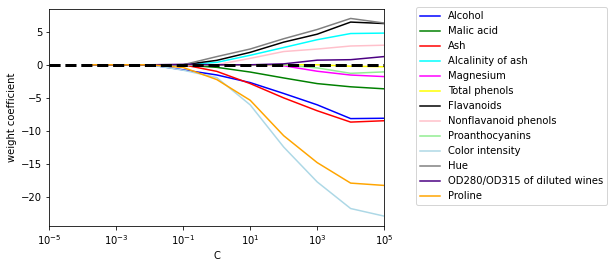

In [43]:
# 규제 강도를 달리하여 특성의 가중치 변화를 그래프로 표현해 보기
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 
          'lightblue', 'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(solver='liblinear', penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

### 4.5.4 순차 특성 선택 알고리즘
차원 축소의 기법 두 가지:  
1) 특성 선택: 원본 특성에서 일부를 선택
2) 특성 추출: 일련의 특성에서 얻은 정보로 새로운 특성을 만듦

순차 특성 선택 알고리즘은 탐욕적 탐색 알고리즘으로 초기 $d$ 차원의 특성 공간을 $k<d$인 $k$ 차원의 특성 부분 공간으로 축소  
순차 후진 선택 (sequential backward selection, SBS)  

NOTE: 탐욕적 알고리즘은 조합 탐색 문제의 각 단계에서 국부적으로 최적의 선택을 함. 일반적으로 해당 문제에 대한 차선의 솔루션을 만듦  

새로운 특성의 부분 공간이 목표하는 특성 개수가 될 때까지 전체 특성에서 순차적으로 특성을 제거  
1) 각 단계에서 어떤 특성을 제거할지 판단하기 위해 최대화할 기준 함수를 정의
2) 기준 함수 값 = 어떤 특성을 제거하기 전후의 모델 성능 차이
3) 기준 값이 가장 큰 특성 제거
4) 제거했을 때 성능 손실이 최소가 되는 특성을 제거

In [44]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from SBS import *

knn = KNeighborsClassifier(n_neighbors=5)

sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)


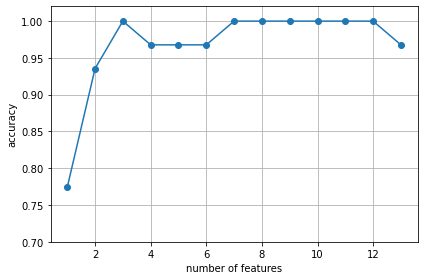

In [45]:
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('accuracy')
plt.xlabel('number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [46]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [47]:
knn.fit(X_train_std, y_train)
print("훈련 정확도: ", knn.score(X_train_std, y_train))
print("테스트 정확도: ", knn.score(X_test_std, y_test))

훈련 정확도:  0.967741935483871
테스트 정확도:  0.9629629629629629


In [48]:
knn.fit(X_train_std[:, k3], y_train)
print("훈련 정확도: ", knn.score(X_train_std[:, k3], y_train))
print("테스트 정확도: ", knn.score(X_test_std[:, k3], y_test))

훈련 정확도:  0.9516129032258065
테스트 정확도:  0.9259259259259259


In [50]:
# 이제 (0.24 버전 이상)는 scikit-learn에서 지원한다.
from sklearn.feature_selection import SequentialFeatureSelector

scores = []
for n_features in range(1, 13):
    sfs = SequentialFeatureSelector(knn, n_features_to_select=n_features, n_jobs=-1)
    sfs.fit(X_train_std, y_train)
    f_mask = sfs.support_
    knn.fit(X_train_std[:, f_mask], y_train)
    scores.append(knn.score(X_train_std[:, f_mask], y_train))

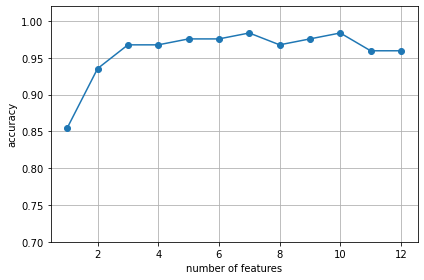

In [51]:
plt.plot(range(1, 13), scores, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('accuracy')
plt.xlabel('number of features')
plt.grid()
plt.tight_layout()
plt.show()